In [102]:
%load_ext autoreload
%autoreload 2

from configs import project_config
import pickle
import numpy as np
import torch
import os
from src.generative_modelling.models.ClassVPSDEDiffusion import VPSDEDiffusion
from src.generative_modelling.models.TimeDependentScoreNetworks.ClassConditionalLSTMTSPostMeanScoreMatching  import \
    ConditionalLSTMTSPostMeanScoreMatching

import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [103]:
from src.classes.ClassFractionalBiPotential import FractionalBiPotential
from configs.RecursiveVPSDE.LSTM_fQuadSinHF.recursive_LSTM_PostMeanScore_fQuadSinHF_T256_H05_tl_110data import get_config as get_config
from src.classes.ClassFractionalQuadSin import FractionalQuadSin
#from configs.RecursiveVPSDE.LSTM_fBiPot.recursive_LSTM_PostMeanScore_fBiPot_T256_H05_tl_110data_SbleTgt_WRMSE import get_config as get_config
config = get_config()
print(config.data_path)
print(config.scoreNet_trained_path)
num_paths = 0
num_time_steps = config.ts_length
isUnitInterval = True
diff = 1
initial_state = 0.
rvs = None
H = 0.5
deltaT = config.deltaT
t0 = config.t0
t1 = config.t1
if "QuadSin" in config.data_path:
    fBiPot = FractionalQuadSin(quad_coeff=config.quad_coeff, sin_space_scale=config.sin_space_scale, sin_coeff = config.sin_coeff, diff=diff, X0=initial_state)
elif "BiPot" in config.data_path:
    fBiPot = FractionalBiPotential(num_dims=config.ndims, quartic_coeff=config.quartic_coeff, quad_coeff=config.quad_coeff, const = config.const, diff=diff, X0=initial_state)
if num_paths > 0:
    sim_data = np.array(
        [fBiPot.euler_simulation(H=H, N=num_time_steps, deltaT=deltaT, isUnitInterval=isUnitInterval, X0=initial_state, Ms=None, gaussRvs=rvs,
                               t0=t0, t1=t1) for _ in (range(num_paths))]).reshape((num_paths, num_time_steps+1))

    plt.hist(sim_data.flatten(), density=True, bins=150)
    print(max(np.abs(sim_data.flatten())))
    plt.show()
    plt.close()
diffs = []
paths = []
for k in range(num_paths):
    path = sim_data[k,:]
    if "QuadSin" in config.data_path:
        drifts = -2*config.quad_coeff * path[:-1] + config.sin_space_scale*config.sin_coeff*np.sin(config.sin_space_scale*path[:-1])
    elif "BiPot" in config.data_path:
        drifts = -(4*config.quartic_coeff * np.power(path[:-1],3) + config.quad_coeff*path[:-1] + config.const)
    plt.scatter(path[:-1], drifts, s=1, label="True")
    d = (np.diff(path)[np.abs(path[1:])<np.inf])
    if len(d) > 0:
        diffs.append(d)
    paths.append(path)
plt.show()
plt.close()
if num_paths > 0 and ("QuadSin" in config.data_path):
    cs, bins, _ = plt.hist(config.sin_space_scale*np.concatenate(diffs).flatten(), bins=100, density=True, label="Histogram")
    print(max(config.sin_space_scale*np.abs(np.concatenate(diffs).flatten())))
    plt.vlines(x=1., ymin=0., ymax=max(cs), color="orange", label="Frequency Limit")
    plt.legend()
    plt.show()
    plt.close()


/Users/marcos/GitHubRepos/FractionalBrownianMotion/data/fQuadSinHF_samples_t00_dT3906e-03_T256_05a_004b_250c_10Diff_00Init.npy
/Users/marcos/GitHubRepos/FractionalBrownianMotion/src/generative_modelling/trained_models/trained_rec_PM_TSM_2LFac_fQuadSinHF_VPSDE_H50e-01_T256_Ndiff10000_Tdiff1000e+00_trainEps1e-04_BetaMax20e+01_BetaMin00e+00_DiffEmbSz64_ResLay10_ResChan8_DiffHdnSz64_TrueHybd_TrueWghts_t00_dT3906e-03_05a_004b_250c_LSTM_H20_Nly1_tl110


In [104]:
def rmse_ignore_nans(y_true, y_pred):
    assert (y_true.shape[0] == y_pred.shape[0])
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)  # Ignore NaNs in both arrays
    return np.sqrt(np.mean((y_true[mask] - y_pred[mask]) ** 2))
def plot_drift_estimator(mean, mean_min, mean_max, numpy_Xs, true_drift,Nepoch, toSave:bool = True):
    if "BiPot" in config.data_path:
        if "_ST_" in config.scoreNet_trained_path:
            ts_type_str = "ST_fBiPot"
        else:
            ts_type_str = "fBiPot"
    elif "QuadSinHF" in config.data_path:
        if "_ST_" in config.scoreNet_trained_path:
            ts_type_str = "ST_fQuadSinHF"
        else:
            ts_type_str = "fQuadSinHF"
    print(ts_type_str)
    fig, ax = plt.subplots(figsize=(14,9))
    rmse = rmse_ignore_nans(true_drift, mean).astype(np.float64)#np.power(np.mean(np.power(true_drift - mean, 2)), 0.5)
    ax.scatter(numpy_Xs, true_drift, color="red", label="True Drift")
    ymin = mean-mean_min
    ymax = mean_max - mean
    ymin[ymin < 0.] = 0.
    ymax[ymax < 0.] = 0.
    plt.errorbar(numpy_Xs,mean,yerr=[ymin, ymax],xerr=None, fmt='o', color="blue", alpha=0.4)
    plt.scatter(numpy_Xs, mean, label="Estimated Drift", color="blue")
    ax.set_title(rf"RMSE {round(rmse,3)} for LSTM Score Estimator", fontsize=40)
    ax.tick_params(labelsize=38)
    ax.set_xlabel("State $X$", fontsize=38)
    ax.set_ylabel("Drift Value", fontsize=38)
    ax.legend(fontsize=24)
    plt.tight_layout()
    if toSave:
        if "BiPot" in config.data_path:
            if "_ST_" in config.scoreNet_trained_path:
                plt.savefig((f"/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModelPresentationImages/{ts_type_str}_ST_DriftEvalExp_PM_LSTM_{Nepoch}Nep_{config.deltaT:.3e}dT_{config.loss_factor}LFac").replace(".","")+".png",  bbox_inches='tight')
            else:
                plt.savefig((f"/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModelPresentationImages/{ts_type_str}_DriftEvalExp_PM_LSTM_{Nepoch}Nep_{config.deltaT:.3e}dT_{config.loss_factor}LFac").replace(".","")+".png",  bbox_inches='tight')
        elif "QuadSinHF" in config.data_path:
            if "004b" in config.data_path:
                if "_ST_" in config.scoreNet_trained_path:
                    plt.savefig((f"/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModelPresentationImages/{ts_type_str}2_ST_DriftEvalExp_PM_LSTM_{Nepoch}Nep_{config.deltaT:.3e}dT_{config.loss_factor}LFac").replace(".","")+".png",  bbox_inches='tight')
                else:
                     plt.savefig((f"/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModelPresentationImages/{ts_type_str}2_DriftEvalExp_PM_LSTM_{Nepoch}Nep_{config.deltaT:.3e}dT_{config.loss_factor}LFac").replace(".","")+".png",  bbox_inches='tight')
            else:
                if "_ST_" in config.scoreNet_trained_path:
                    plt.savefig((f"/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModelPresentationImages/{ts_type_str}1_ST_DriftEvalExp_PM_LSTM_{Nepoch}Nep_{config.deltaT:.3e}dT_{config.loss_factor}LFac").replace(".","")+".png",  bbox_inches='tight')
                else:
                    plt.savefig((f"/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModelPresentationImages/{ts_type_str}1_DriftEvalExp_PM_LSTM_{Nepoch}Nep_{config.deltaT:.3e}dT_{config.loss_factor}LFac").replace(".","")+".png",  bbox_inches='tight')
    plt.show()
    plt.close()

In [105]:
config = get_config()
print(config.beta_min)
if config.has_cuda:
    device = int(os.environ["LOCAL_RANK"])
else:
    print("Using CPU\n")
    device = torch.device("cpu")

diffusion = VPSDEDiffusion(beta_max=config.beta_max, beta_min=config.beta_min)

max_diff_steps = config.max_diff_steps
sample_eps = config.sample_eps
ts_step = config.deltaT

0.0
Using CPU



fQuadSinHF


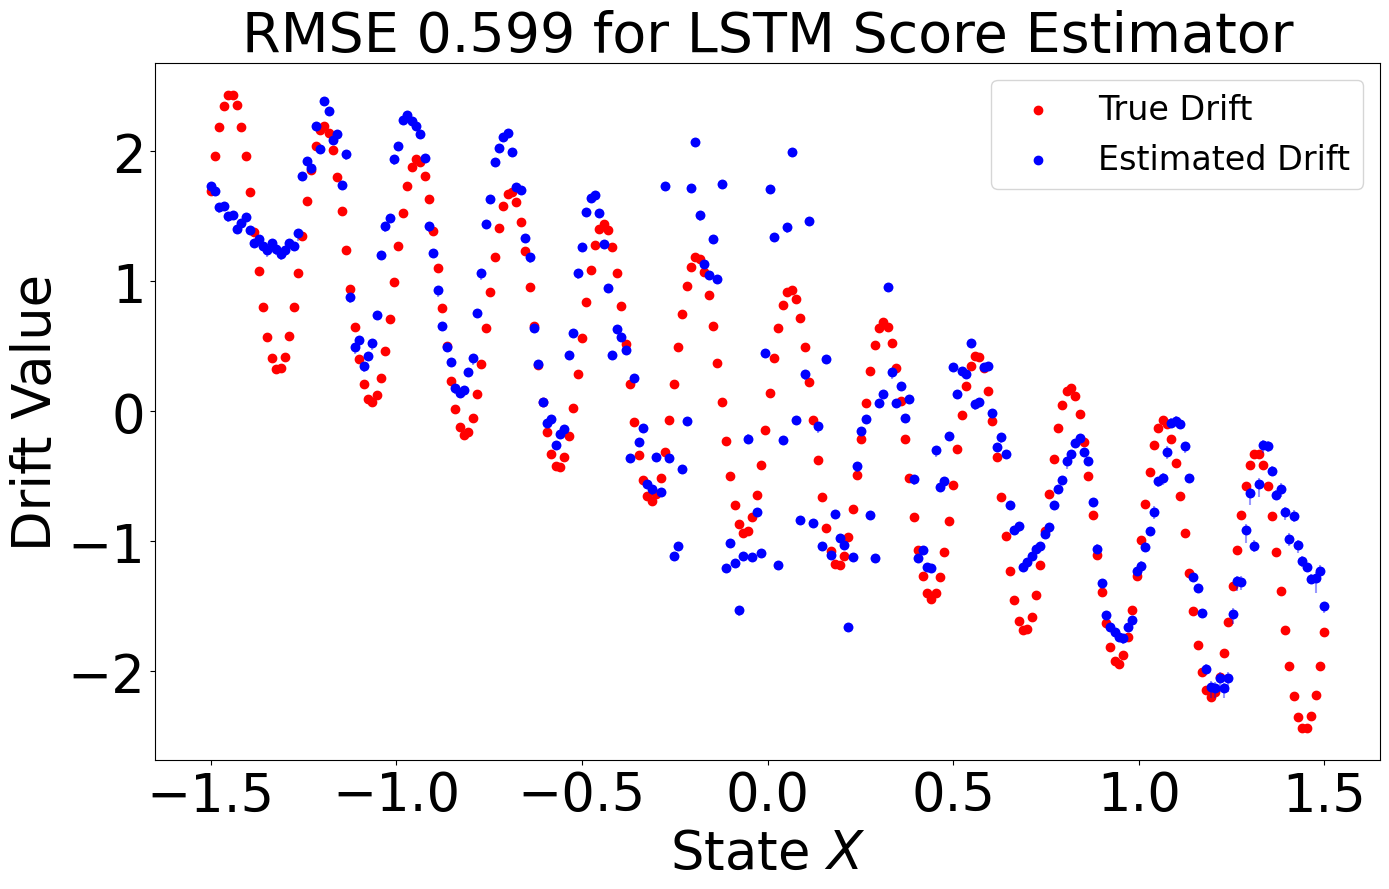

RuntimeError: 

In [106]:
best_rmse = np.inf
toSave = True
for Nepoch in np.arange(4682,config.max_epochs[-1]):
    try:
        Ndiff = config.max_diff_steps
        if "PMS" in config.scoreNet_trained_path:
            type = "PMS"
        elif "PM" in config.scoreNet_trained_path:
            type = "PM"
        else:
            type = ""
        if "fQuadSinHF" in config.data_path:
            if "_ST_" in config.scoreNet_trained_path:
                file_path = (project_config.ROOT_DIR + f"experiments/results/TSPM_LSTM_ST_fQuadSinHF_DriftEvalExp_{Nepoch}Nep_{config.t0}t0_{config.deltaT:.3e}dT_{config.quad_coeff}a_{config.sin_coeff}b_{config.sin_space_scale}c_{config.residual_layers}ResLay_{config.loss_factor}LFac_").replace(
                                ".", "")
            else:
                file_path = (project_config.ROOT_DIR + f"experiments/results/TSPM_LSTM_fQuadSinHF_DriftEvalExp_{Nepoch}Nep_{config.t0}t0_{config.deltaT:.3e}dT_{config.quad_coeff}a_{config.sin_coeff}b_{config.sin_space_scale}c_{config.residual_layers}ResLay_{config.loss_factor}LFac_").replace(
                                ".", "")
        elif "fBiPot" in config.data_path:
            if "_ST_" in config.scoreNet_trained_path:
                file_path = (
                            project_config.ROOT_DIR + f"experiments/results/TS{type}_LSTM_ST_fBiPot_DriftEvalExp_{Nepoch}Nep_{config.t0}t0_{config.deltaT:.3e}dT_{config.quartic_coeff}a_{config.quad_coeff}b_{config.const}c_{config.residual_layers}ResLay_{config.loss_factor}LFac_").replace(
                        ".", "")
            else:
                file_path = (
                            project_config.ROOT_DIR + f"experiments/results/TS{type}_LSTM_fBiPot_DriftEvalExp_{Nepoch}Nep_{config.t0}t0_{config.deltaT:.3e}dT_{config.quartic_coeff}a_{config.quad_coeff}b_{config.const}c_{config.residual_layers}ResLay_{config.loss_factor}LFac_").replace(
                        ".", "")

        muhats = torch.Tensor(np.load(file_path+"muhats.npy"))
        Xshape = muhats.shape[0]
        if "fQuadSinHF" in config.data_path:
            if config.deltaT > 1/(32*256):
                Xs = torch.linspace(-1.5, 1.5, steps=Xshape)
            else:
                Xs = torch.linspace(-.4, .4, steps=Xshape)
            ts_type = "fQuadSinHF"
        elif "fSin" in config.data_path:
            Xs = torch.Tensor(np.linspace(-3,3,Xshape))#np.load(file_path+"numpyXs.npy"))
            ts_type = "fSin"
        elif "fBiPotSmall" in config.data_path:
            Xs = torch.Tensor(np.linspace(-1.5,1.5,Xshape))#np.load(file_path+"numpyXs.npy"))
            ts_type="fBiPotSmall"
        elif "fBiPot" in config.data_path:
            Xs = torch.Tensor(np.linspace(-1.5,1.5,Xshape))#np.load(file_path+"numpyXs.npy"))
            ts_type="fBiPot"
        if type == "":
            type="Standard"
        assert (config.max_diff_steps == 10000)
        if "fQuadSin" in config.data_path:
            true_drifts = -2.*config.quad_coeff * Xs.unsqueeze(-1) + config.sin_coeff * config.sin_space_scale*np.sin(config.sin_space_scale*Xs).unsqueeze(-1)
        elif "fSin" in config.data_path:
            true_drifts = config.mean_rev*np.sin(1*Xs).unsqueeze(-1)
        elif "BiPot" in config.data_path:
            true_drifts = -(4.*config.quartic_coeff * np.power(Xs, 3) + 2.*config.quad_coeff * Xs + config.const).unsqueeze(-1)
            #true_drifts = true_drifts/(1.+config.deltaT*torch.abs(true_drifts))
        muhats =  muhats[:, -1, :].reshape(muhats.shape[0], muhats.shape[-1]*1)
        mu_hats = muhats.mean(dim=-1).numpy() # Pointwise drift estimate
        mu_hats_minq = muhats.quantile(dim=-1, q=0.025).numpy() # Lower bound
        mu_hats_maxq = muhats.quantile(dim=-1, q=0.975).numpy() # Lower bound
        stds = muhats.std(dim=-1).numpy()
        rmse = rmse_ignore_nans(true_drifts.numpy(), mu_hats).astype(np.float64)#np.power(np.mean(np.power(true_drift - mean, 2)), 0.5)
        if rmse < best_rmse:
            best_rmse = rmse
            plot_drift_estimator(mean=mu_hats, mean_min=mu_hats_minq, mean_max=mu_hats_maxq, numpy_Xs=Xs.numpy(),  toSave=toSave, true_drift=true_drifts.numpy(), Nepoch=Nepoch)
        del muhats, mu_hats, stds, true_drifts
        raise RuntimeError
    except FileNotFoundError as e:
        continue

In [ ]:
best_rmse